<h1 align=centre> Fine-Tuning BERT using tensorflow and tf_hub</h2>
<h1 align=centre> on semantic sentence pairs classification</h2>

In this project we'll see how to fine-tune BERT for sentence pairs classification problem using Tensorflow and tf_hub . 

The pre-trained BERT models are available at [tensorflow hub](https://tfhub.dev/). 

# Table of contents:

- **[Step 1]()**: Installing tensorflow Model garden pakage and other required dependencies 
- **[Step 2]()**: Mounting Google Drive and importing DataSet 
- **[Step 3]()**: Importing libraires and defining BERT path URL

- **[Step 4]()**: Preprocessing Data using separate Tensorflow model 
- **[Step 5]()**: Creating a TensorFlow Input Pipeline with `tf.data`
- **[Step 6]()**: Adding a Classification Head to the BERT `hub.KerasLayer` Execution
- **[Step 7]()**: Fine-Tuning BERT for sentence pairs Classification
- **[Step 8]()**: Evaluating Model performance visually 
- **[Step 9]()**: Exporting Model for Inference
- **[Step 10]()**: Testing our BERT Model

### Step 1: Installing tensorflow Model garden pakage and other required dependencies 


You have to restart your kernel in Google Colab after executing below 3 cells by clicking on same `Runtime` menu and then choosing `Restart runtime` . However if you're using local jupyter notebook then just restart your kernel by above menu list. 

Restarting kernel isn't necessary but good to do

In [ ]:
pip install -q -U tensorflow-text


     |████████████████████████████████| 4.9 MB 3.8 MB/s 


In [ ]:
# To create Adamw optimizor
!pip install -q tf-models-official


     |████████████████████████████████| 1.8 MB 4.4 MB/s 
     |████████████████████████████████| 99 kB 8.0 MB/s 
     |████████████████████████████████| 90 kB 8.8 MB/s 
     |████████████████████████████████| 596 kB 44.2 MB/s 
     |████████████████████████████████| 1.1 MB 39.2 MB/s 
     |████████████████████████████████| 352 kB 15.9 MB/s 
     |████████████████████████████████| 47.6 MB 1.8 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 1.2 MB 51.9 MB/s 
     |████████████████████████████████| 213 kB 41.8 MB/s 


In [ ]:
pip install -U tfds-nightly


     |████████████████████████████████| 4.1 MB 4.4 MB/s 


### Step 2: Mounting Google Drive and importing DataSet

In below cells we will mount Google Drive, as this project is done using Google Colab so we can't just import our data from local disk space . Instead we will first upload it on Google Drive then mount it here in Colab in order to get access to Data . 

You can skip this step and directly import Data from local disk space if you're using Jupyter Notebook

In [ ]:
## Importing basic libraires

import numpy as np
import pandas as pd
pd.set_option('display.width',1000)
pd.set_option('max_colwidth', 1000) 
import os


In [ ]:
## Mounting google drive

from google.colab import drive
drive.mount('gdrive') 

Mounted at gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Colab DataSets/upwork_data/

/content/gdrive/MyDrive/Colab DataSets/upwork_data


In [ ]:
## Importing DataSet and limiting only to first 5000 rows to save time and to avoid memory errors 
## If you have high RAM then just remove the argument 'nrows' given below

df = pd.read_csv('address-result.csv' , encoding = 'utf-8',
                  nrows=5000)
df.head()

,address,location,score
0,荃灣葵涌陳氏家祠,陳氏家祠,1
1,荃灣葵涌陳氏家祠,上葵涌村陳氏家祠,0
2,荃灣葵涌陳氏家祠,陳氏祠堂,0
3,葵青葵涌關帝廟,關帝廟,1
4,葵青葵涌關帝廟,關帝古廟,0


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   address   5000 non-null   object
 1   location  5000 non-null   object
 2   score     5000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 117.3+ KB
None


In [ ]:
## It is important to note maximum length of sentences, in your case it would be greater/different
## based on length value we will set 'seq_length' argument below ( it will be a bit greater then either of address/location maximum length value)

total_address = []
total_location = []

for address in df['address']:
  total_address.append(len(address))

for location in df['location']:
  total_location.append(len(location))

print("Maximum address length is : {}".format(max(total_address)))
print("\nMaximum location length is : {}".format(max(total_location)))

Maximum address length is : 36

Maximum location length is : 21


In [ ]:
df['score'].value_counts()

0    2901
1    2099
Name: score, dtype: int64

In [ ]:
## Splitting our Data into Train & tests sets for our model 

import sklearn
from sklearn.model_selection import train_test_split

train_df, remaining  = train_test_split(df[['address','location','score']], stratify = df['score'], test_size = 0.1)
test_df, remaining  = train_test_split(remaining[['address','location','score']], stratify = remaining['score'], test_size = 0.1)


print(train_df.shape)
print(test_df.shape)

(4500, 3)
(450, 3)


In [ ]:
del(df)
del(remaining)
test_df.head()

,address,location,score
870,荃灣青龍頭青山公路 － 青龍頭段15號,青山公路 － 青龍頭段15號,1
4394,油尖旺區尖沙咀漆咸道南125-127號天主教玫瑰堂,聖母玫瑰堂,0
1048,葵青葵涌永順街26A號,永順街26號A,1
1428,九龍城筆架山安域道2號映月臺,安域道2號,1
1512,觀塘九龍灣啓樂街15號九龍灣體育館,啓樂街15號,1


### Step 3: Importing libraires and defining BERT path URL

Here we will all modules from libraires we have installed in the beginning in order to perfrom certain tasks and modeling methods. 

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
from official.nlp import optimization  # to create AdamW optimizer
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks
tf.get_logger().setLevel('ERROR')


In [ ]:
# Model URL
hub_bert_url = "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4"
# Preprocessor URL
hub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3"


# Here you can see we are able to preprocess our inputs
bert_preprocess = hub.load(hub_handle_preprocess)
text_1a = "觀塘藍田啟田道71號藍田（西區）社區中心"
text_1b = "啟田道67號"

tok_1a = bert_preprocess.tokenize([text_1a])
tok_1b = bert_preprocess.tokenize([text_1b])


### Step 4: Preprocessing Data using separate Tensorflow model

Here we will define a Tensorflow model specially for preprocessing raw text inputs into a form that BERT accepts. We will define this model to directly pass our full Data to be processed all at once. BERT accepts 3 inputs `input_type_ids`, `input_word_ids` & `input_mask`



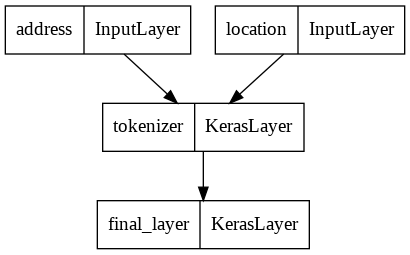

In [ ]:
## See below output plot . It will take Address and location as inputs and then final_layer will give BERT expected inputs

preprocessor = hub.load(
    "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")

def pre_func(sentences):
  
  
  
  # Step 1: tokenize batches of text inputs.
  text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string, name = ft) for ft in sentences] # This SavedModel accepts up to 2 text inputs.
  #label_input = tf.keras.layers.Input(shape=(), dtype=tf.int32,
   #                                      name = label)
  tokenize = hub.KerasLayer(preprocessor.tokenize, name = "tokenizer")
  tokenized_inputs = [tokenize(segment) for segment in text_inputs]

  # Step 2 (optional): modify tokenized inputs.
  pass

  # Step 3: pack input sequences for the Transformer encoder.
  seq_length = 40  # Your choice here. ( Change value 40 to another value based on either Address/location maximum length )
  bert_pack_inputs = hub.KerasLayer(
      preprocessor.bert_pack_inputs,
      name = "final_layer",
      arguments=dict(seq_length=seq_length))  # Optional argument.
  encoder_inputs = bert_pack_inputs(tokenized_inputs)
  #encoder_inputs = (encoder_inputs, label_input)
  return tf.keras.Model(text_inputs, encoder_inputs)



bert_preprocessor = pre_func(['address','location'])
tf.keras.utils.plot_model(bert_preprocessor)


In [ ]:
## Testing our above preprocess model to process raw inputs into 'input_type_ids', 'input_word_ids' & 'input_mask'

text_1a = "觀塘藍田啟田道71號藍田（西區）社區中心"
text_1b = "啟田道67號"

text_preprocessed = bert_preprocessor([np.array([text_1a]), np.array([text_1b])])
print(type(text_preprocessed))
text_preprocessed['input_word_ids']

<class 'dict'>


<tf.Tensor: shape=(1, 40), dtype=int32, numpy=
array([[  101,  7155,  3126,  6916,  5610,  2898,  5610,  7761, 12513,
         6951,  6916,  5610, 10060,  7138,  2665, 10061,  5900,  2665,
         2104,  3792,   102,  2898,  5610,  7761, 12316,  6951,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]], dtype=int32)>

In [ ]:
text_4a = "九龍城橫頭磡范信達道2號雅芳園"
text_4b = "雅芳園"

output = bert_preprocessor([np.array([text_4a]), np.array([text_4b])])
print(type(output))
output['input_word_ids']


<class 'dict'>


<tf.Tensor: shape=(1, 40), dtype=int32, numpy=
array([[ 101, 2133, 8833, 3086, 4744, 8391, 5886, 6724, 2316, 7762, 7761,
         123, 6951, 8271, 6692, 3023,  102, 8271, 6692, 3023,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]], dtype=int32)>

In [ ]:
# preparing test data / validation data as per BERT requirements

bert_inputs_val = bert_preprocessor([np.array(test_df['address']), np.array(test_df['location'])])
print(type(bert_inputs_val))
bert_inputs_val['input_word_ids'][:5]

<class 'dict'>


<tf.Tensor: shape=(5, 40), dtype=int32, numpy=
array([[  101,  6743,  5255,  8325,  8833,  8391,  8325,  3504,  2452,
         7559,   100, 10065,   100,  8325,  8833,  8391,  4823, 10208,
         6951,   102,  8325,  3504,  2452,  7559,   100, 10065,   100,
         8325,  8833,  8391,  4823, 10208,  6951,   102,     0,     0,
            0,     0,     0,     0],
       [  101,  4929,  3463,  4358,  2665,  3463,  4914,  2828,  5157,
         2851,  7761,  2682, 14048,   118, 17592,  6951,  3198,  2111,
         4297,  5485,  5557,  3102,   102,  6480,  4834,  5485,  5557,
         3102,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [  101,  6837,  8325,  6837,  5012,  4870,  8376,  7073, 10314,
        10738,  6951,   102,  4870,  8376,  7073, 10314,  6951,   138,
          102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0

In [ ]:
# Validation data labels
bert_labels_val = tf.convert_to_tensor(test_df['score'])

# preparing train data for BERT and train labels
bert_inputs_train = bert_preprocessor([np.array(train_df['address']), np.array(train_df['location'])])

# Train data labels
bert_labels_train = tf.convert_to_tensor(train_df['score'])


In [ ]:

print(" Total training examples : ",len(bert_inputs_train['input_word_ids']))
print(" Total inputs BERT will take : ",bert_inputs_train.keys())
print(" Total length of labels for training : ",len(bert_labels_train))
print(" Type of BERT inputs : ",type(bert_inputs_train), \
       "\n Type of training labels : ",type(bert_labels_train))

 Total training examples :  4500
 Total inputs BERT will take :  dict_keys(['input_mask', 'input_word_ids', 'input_type_ids'])
 Total length of labels for training :  4500
 Type of BERT inputs :  <class 'dict'> 
 Type of training labels :  <class 'tensorflow.python.framework.ops.EagerTensor'>


### Step 5: Creating a TensorFlow Input Pipeline with `tf.data`

In [ ]:
## Before passing above bert_inputs directly to model we must combine inputs with respected labels for both train & Validation sets
## Below function will do this and finally create a Tensor Object that's the final Train & Validation sets we'll pass to our model
## We will also specify batch of inputs (32 in our case) that at a time our model will process  

def to_feature_map(bert_dict, labels):

  AUTOTUNE = tf.data.AUTOTUNE
  x = (bert_dict,labels)
  with tf.device('/cpu:0'):
    final_data = tf.data.Dataset.from_tensor_slices(x).shuffle(1000).batch(32 , drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)
  return final_data



In [ ]:
# Creating training data for BERT
train_data = to_feature_map(bert_inputs_train, bert_labels_train)

# Creating validation data for BERT
validation_data = to_feature_map(bert_inputs_val, bert_labels_val)


In [ ]:
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 40), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 40), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 40), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

In [ ]:
train_data.take(1)

<TakeDataset shapes: ({input_mask: (32, 40), input_word_ids: (32, 40), input_type_ids: (32, 40)}, (32,)), types: ({input_mask: tf.int32, input_word_ids: tf.int32, input_type_ids: tf.int32}, tf.int64)>

### Step 6: Adding a Classification Head to the BERT `hub.KerasLayer`

Now as we will use a BERT multi-lingual model we will defitely fine-tune it on our own DataSet . That's why we will customize it a bit by adding a few layers. 
See below picture 

<div align="right">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [ ]:
max_seq_length = 40 # You will change it also based on either of address/location max length


# Building the model
def create_model():

  """
  Well this is pure Tensorflow model !!!
  1. We are defining 3 layers to accept 3 inputs for BERT
  2. We will make then as dictionary and load a BERT model from given link
  3. We will pass it to BERT and in-return pick the pooled_output results for classification
  4. We add a dropout layer & final layer for classification 
  """
  
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name = "input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name = "input_mask")
  input_type_ids=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name = "input_type_ids")
  
  encoder_inputs = dict(input_word_ids = input_word_ids ,input_mask = input_mask,input_type_ids = input_type_ids  )
  bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4" , trainable = True , name = 'encoder')
  
  outputs  = bert_layer(encoder_inputs)
  pooled_output = outputs["pooled_output"]      
  
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(2, activation=None, name="output")(drop)

  model = tf.keras.Model(
      inputs={
      'input_word_ids': input_word_ids,
       'input_mask': input_mask,
       'input_type_ids': input_type_ids
  },
      outputs=output)
  return model


In [ ]:
## Let's test our model on sample Data 

test_classifier_model = create_model()
bert_raw_result = test_classifier_model(text_preprocessed)
tf.sigmoid(bert_raw_result)


<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.51676756, 0.41768724]], dtype=float32)>

In [ ]:
## Its giving '0' output . Well we haven't trained it just cheking if it's actually working

np.argmax(tf.sigmoid(bert_raw_result))

0

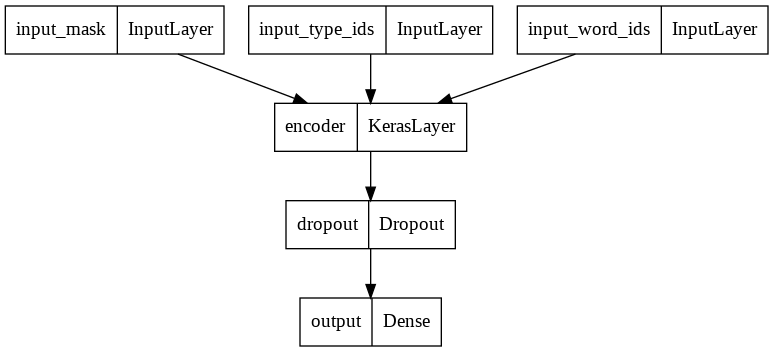

In [ ]:
## Here you can see what's the structure of our Tensorflow BERT model

tf.keras.utils.plot_model(test_classifier_model)


In [ ]:
# Setting configuration for model
# Specifying loss and metrics 

def get_configuration():

  loss = loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),

  metric = tf.keras.metrics.SparseCategoricalAccuracy(
        'accuracy', dtype=tf.float32)

  return metric, loss

### Step 7: Fine-Tuning BERT for sentence pairs Classification
### Optimizor

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [`AdamW`](https://arxiv.org/abs/1711.05101).

For the learning rate (init_lr), we will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (num_warmup_steps). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [ ]:
## Instantiating the model

epochs = 2 # It must be in range of 2-4 
init_lr = 2e-5
train_data_size = 4500 # You will change it based on your train_df size splitting Data
batch_size = 32

steps_per_epoch = train_data_size // batch_size 
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10

classifier_model = create_model()

optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')


In [ ]:
# Compiling the model
metric, loss = get_configuration()

classifier_model.compile(optimizer=optimizer,
              loss=loss,
              metrics = metric)
classifier_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_mask (InputLayer)        [(None, 40)]         0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 encoder (KerasLayer)           {'default': (None,   177853441   ['input_mask[0][0]',             
                                768),                             'input_type_ids[0][0]',   

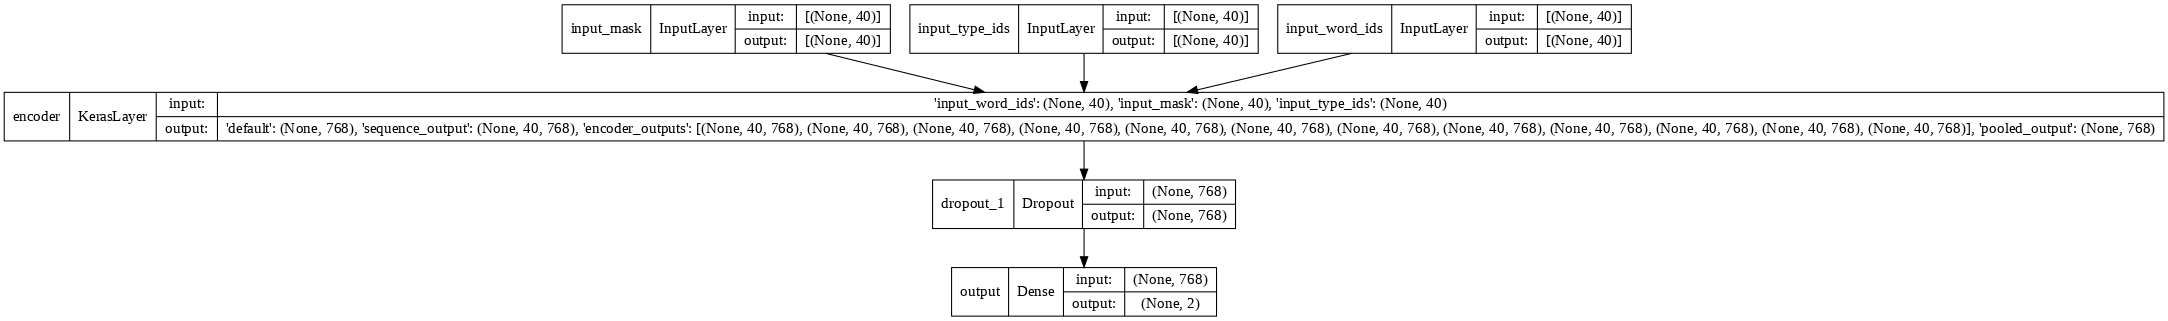

In [ ]:
tf.keras.utils.plot_model(model = classifier_model, show_shapes = True, dpi=76 )

In [ ]:
for text , labls in train_data.take(1):
  print(labls)

tf.Tensor([0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 1], shape=(32,), dtype=int64)


In [ ]:
# Training the model

no_of_valid_examples = 450 # Change this one also based on test_df size
validation_steps = no_of_valid_examples // batch_size

history = classifier_model.fit(
      x=train_data,
      validation_data=validation_data,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_steps=validation_steps)

# It will take much time 

Epoch 1/2
140/140 [==============================] - 2202s 16s/step - loss: 0.2462 - accuracy: 0.8725 - val_loss: 0.0958 - val_accuracy: 0.9710
Epoch 2/2
140/140 [==============================] - 2208s 16s/step - loss: 0.0439 - accuracy: 0.9893 - val_loss: 0.1037 - val_accuracy: 0.9821


### Step 8: Evaluating Model performance visually

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

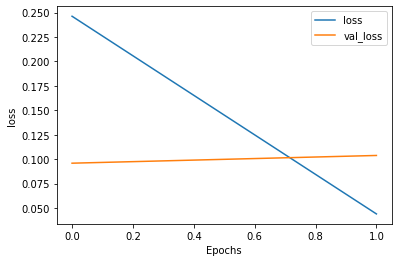

In [ ]:
plot_graphs(history,'loss')

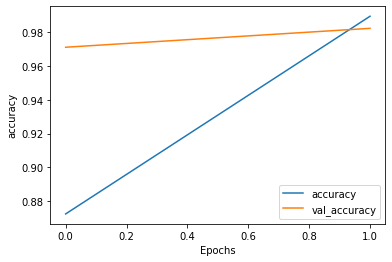

In [ ]:
plot_graphs(history,'accuracy')

## Step 9: Exporting Model for Inference

Here we will save our models . We will save BERT and it's resources like weights etc as well as the preprocessing model we created earlier to process raw text for BERT . We will save the preprocessing model and it's recources like vocab table etc . And then finally at the time of inference we can call both models process our data and get predictions !!

In [ ]:
# Saving our BERT model

tfds_name = 'chinese/sentence_classification'
main_save_path = './my_models_BERT'

bert_type = hub_bert_url.split('/')[-2]
saved_model_name = f'{tfds_name.replace("/", "_")}_{bert_type}'
print(hub_bert_url)
print(bert_type)
print(saved_model_name)

saved_model_path = os.path.join(main_save_path, saved_model_name)
print(saved_model_path)


https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4
bert_multi_cased_L-12_H-768_A-12
chinese_sentence_classification_bert_multi_cased_L-12_H-768_A-12
./my_models_BERT/chinese_sentence_classification_bert_multi_cased_L-12_H-768_A-12


In [ ]:
## Saving model

print(" Saving model ...")
classifier_model.save(saved_model_path)


 Saving model ...


In [ ]:
## Saving preprocessor Model

preprocessor_type = hub_handle_preprocess.split('/')[-2]
saved_preprocessor_name = f'{tfds_name.replace("/", "_")}_{preprocessor_type}'
saved_preprocessor_path = os.path.join(main_save_path, saved_preprocessor_name)

print(hub_handle_preprocess)
print(preprocessor_type)
print(saved_preprocessor_name)
print(saved_preprocessor_path)


print("\nSaving preprocessor model ...")
bert_preprocessor.save(saved_preprocessor_path)


https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3
bert_multi_cased_preprocess
chinese_sentence_classification_bert_multi_cased_preprocess
./my_models_BERT/chinese_sentence_classification_bert_multi_cased_preprocess

Saving preprocessor model ...


### Step 10: Testing our BERT model

Now Let's test our model by reloading fresh models we've just saved and then getting predictions on some sample Data

In [ ]:
## Reloading fresh models 

print(saved_model_path)
print(saved_preprocessor_path)

reloaded_model = tf.saved_model.load(saved_model_path)
reloaded_preprocessor = tf.saved_model.load(saved_preprocessor_path)


./my_models_BERT/chinese_sentence_classification_bert_multi_cased_L-12_H-768_A-12
./my_models_BERT/chinese_sentence_classification_bert_multi_cased_preprocess


In [ ]:
# Function for transforming raw inputs into a format that reloaded_model accepts

sentence_features = ['address', 'location']

def prepare(record):
  model_inputs = [np.array(record[ft]) for ft in sentence_features]
  labels = int(record['score'].values)
  return model_inputs , labels


In [ ]:
## Function to present address. location, score & BERT predicted score

def evaluate(test , label):
  
  l1 = [ i for i in test]
  print(f' Address : {l1[0]} \n Location : {l1[1]}')
  print(" Original score : " , label)
  bert_inputs_dict = reloaded_preprocessor(test)
  result = reloaded_model(bert_inputs_dict)
  print(" BERT predicted score : ", tf.argmax(result, axis=1)[0])    
  print('\n')


In [ ]:
## Testing sample
bert_input, label = prepare(train_df.head(1))
print(" BERT input text : ", bert_input)
print(" Label/Score : ", label)


 BERT input text :  [array(['荃灣葵涌老圍145號淨慧苑'], dtype=object), array(['老圍148號'], dtype=object)]
 Label/Score :  0


In [ ]:
## Testing sample 
bert_input, label = prepare(train_df.sample(1))
evaluate(bert_input , label)


 Address : ['葵青葵涌荔枝嶺路35號仁濟醫院華懋護理安老院'] 
 Location : ['荔枝嶺路35號']
 Original score :  1
 BERT predicted score :  tf.Tensor(1, shape=(), dtype=int64)




In [ ]:
## Testing sample 
bert_input, label = prepare(train_df.sample(1))
evaluate(bert_input , label)


 Address : ['黃大仙九龍城聯合道150號華德學校'] 
 Location : ['崇德學校']
 Original score :  0
 BERT predicted score :  tf.Tensor(0, shape=(), dtype=int64)




In [ ]:
## Testing sample
bert_input, label = prepare(train_df.sample(1))
evaluate(bert_input , label)


 Address : ['觀塘油塘嶺南古廟'] 
 Location : ['東山古廟']
 Original score :  0
 BERT predicted score :  tf.Tensor(0, shape=(), dtype=int64)




In [ ]:
## Testing sample 
bert_input, label = prepare(train_df.sample(1))
evaluate(bert_input , label)


 Address : ['九龍城馬頭圍炮仗街71號嘉景花園'] 
 Location : ['花園街71號']
 Original score :  0
 BERT predicted score :  tf.Tensor(0, shape=(), dtype=int64)




In [ ]:
## Testing sample
bert_input, label = prepare(train_df.sample(1))
evaluate(bert_input , label)


 Address : ['九龍城馬頭圍英才徑4號英才職業技能培訓中心'] 
 Location : ['英才職業技能培訓中心']
 Original score :  1
 BERT predicted score :  tf.Tensor(1, shape=(), dtype=int64)




In [ ]:
## Testing sample 
bert_input, label = prepare(train_df.sample(1))
evaluate(bert_input , label)


 Address : ['屯門三聖墟青山三洲媽廟'] 
 Location : ['三聖廟']
 Original score :  0
 BERT predicted score :  tf.Tensor(0, shape=(), dtype=int64)




In [ ]:
## Testing sample
bert_input, label = prepare(train_df.sample(1))
evaluate(bert_input , label)


 Address : ['深水埗又一村海棠路66號香港基督教女青年會又一村會所賽馬會樓'] 
 Location : ['海棠路68號']
 Original score :  0
 BERT predicted score :  tf.Tensor(0, shape=(), dtype=int64)




In [ ]:
## Testing sample
bert_input, label = prepare(train_df.sample(1))
evaluate(bert_input , label)


 Address : ['離島區大嶼山華嚴閣'] 
 Location : ['華嚴閣']
 Original score :  1
 BERT predicted score :  tf.Tensor(1, shape=(), dtype=int64)




## 😂😂😂 That's all Baby !!!